# Oxford IIIT Pet Classification

## Import necessary modules

In [1]:
from fastai.vision.all import *

## Download and explore dataset

In [2]:
path = untar_data(URLs.PETS)
path

Path('/home/gurucharan/.fastai/data/oxford-iiit-pet')

In [3]:
path.ls()

(#4) [Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/models'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/feature_dict.p'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images')]

In [4]:
fnames = get_image_files(path/"images")
fnames

(#7390) [Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_120.jpg'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images/boxer_33.jpg'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images/Birman_105.jpg'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images/american_bulldog_199.jpg'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images/boxer_169.jpg'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images/newfoundland_162.jpg'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images/great_pyrenees_199.jpg'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images/beagle_114.jpg'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images/chihuahua_30.jpg'),Path('/home/gurucharan/.fastai/data/oxford-iiit-pet/images/Ragdoll_12.jpg')...]

## Create DataLoaders through DataBlock

In [5]:
item_tfms = RandomResizedCrop(460, min_scale=0.8, ratio=(1., 1.))
batch_tfms = [*aug_transforms(size=224, max_warp=0.15), Normalize.from_stats(*imagenet_stats)]

In [6]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(), 
    get_y=RegexLabeller(pat=r"/([^/]+)_\d+.*"), 
    item_tfms=item_tfms, 
    batch_tfms=batch_tfms)

In [7]:
bs = 64
dls = pets.dataloaders(path/"images", bs=bs)

### Visualizing dataset

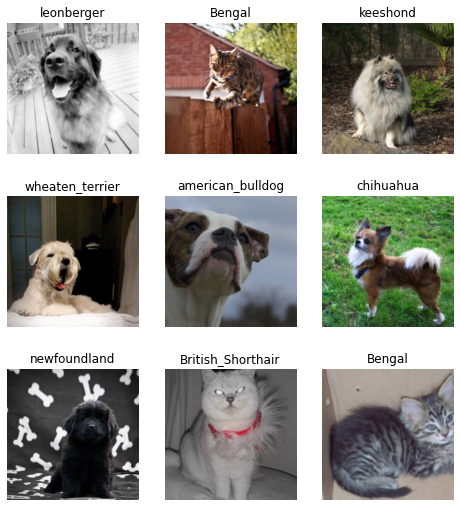

In [8]:
dls.show_batch(max_n=9, figsize=(8, 9))

In [9]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [10]:
dls.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

## Create Learner with pretrained Resnet34

In [11]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[error_rate, accuracy]).to_fp16()

### Find optimal learning rate

/home/gurucharan/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.005248074419796467)

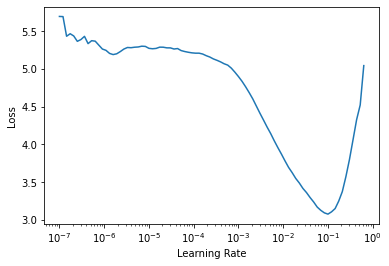

In [12]:
learn.lr_find()

In [13]:
learn.fit_one_cycle(4, slice(7e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.064888,0.360427,0.112991,0.887010,00:34
1,0.569560,0.291466,0.088633,0.911367,00:35
2,0.365232,0.270592,0.076455,0.923545,00:35
3,0.238918,0.233724,0.067659,0.932341,00:35


In [14]:
learn.save("stage1")

Path('models/stage1.pth')

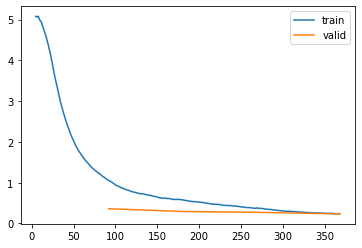

In [15]:
learn.recorder.plot_loss()

## One cycle scheduler with cosine annealing

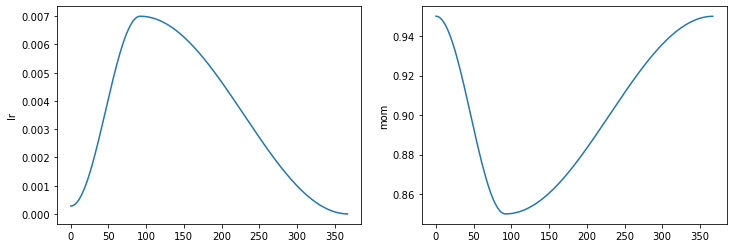

In [16]:
learn.recorder.plot_sched()

### Unfreeze the body and train

In [17]:
learn.unfreeze()

SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=9.12010818865383e-07)

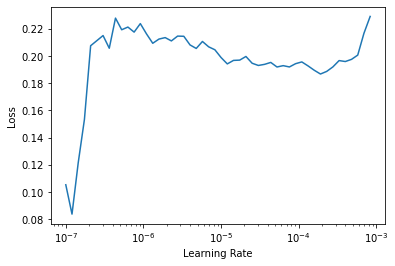

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(4, slice(7e-7, 7e-6))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.197145,0.233139,0.065629,0.934371,00:44
1,0.172939,0.233602,0.068336,0.931664,00:44
2,0.183962,0.231232,0.065629,0.934371,00:44
3,0.176449,0.229787,0.066306,0.933694,00:44


### Visualize trained the model results

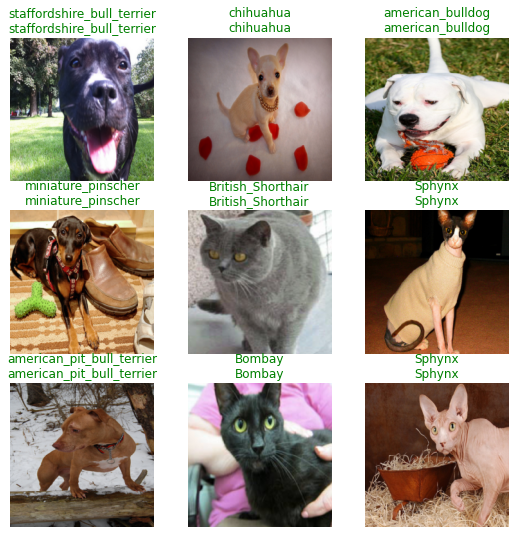

In [20]:
learn.show_results()

## Interpret the model and analyze top losses

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

len(dls.valid_ds) == len(losses) == len(idxs)

True

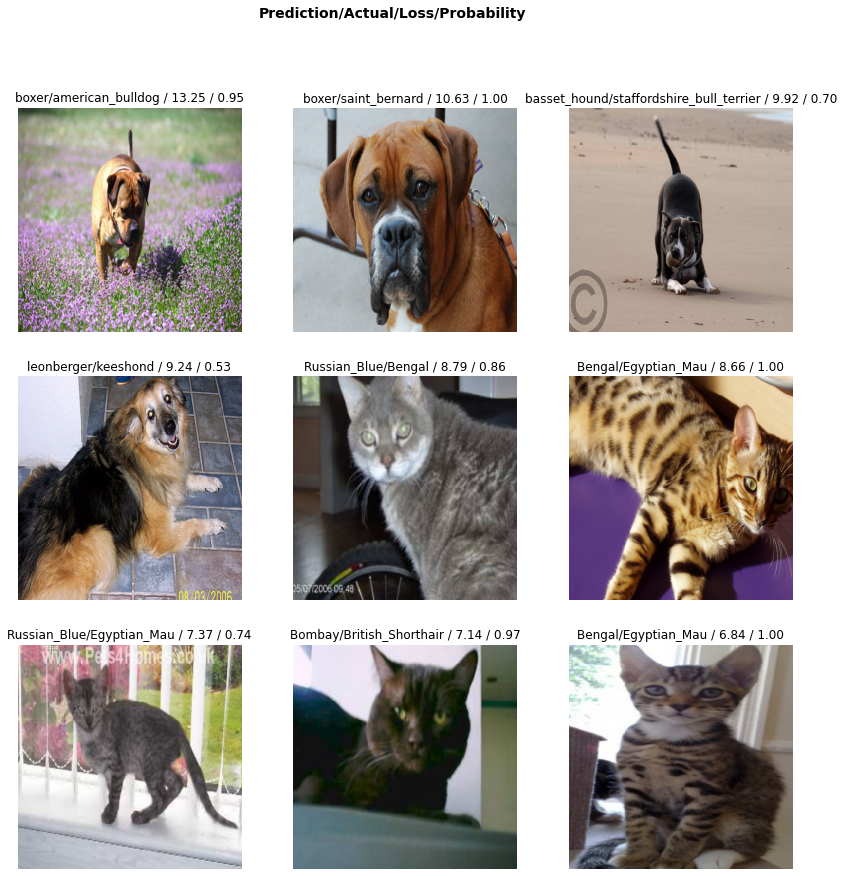

In [22]:
interp.plot_top_losses(9, figsize=(14, 14))

### Confusion Matrix

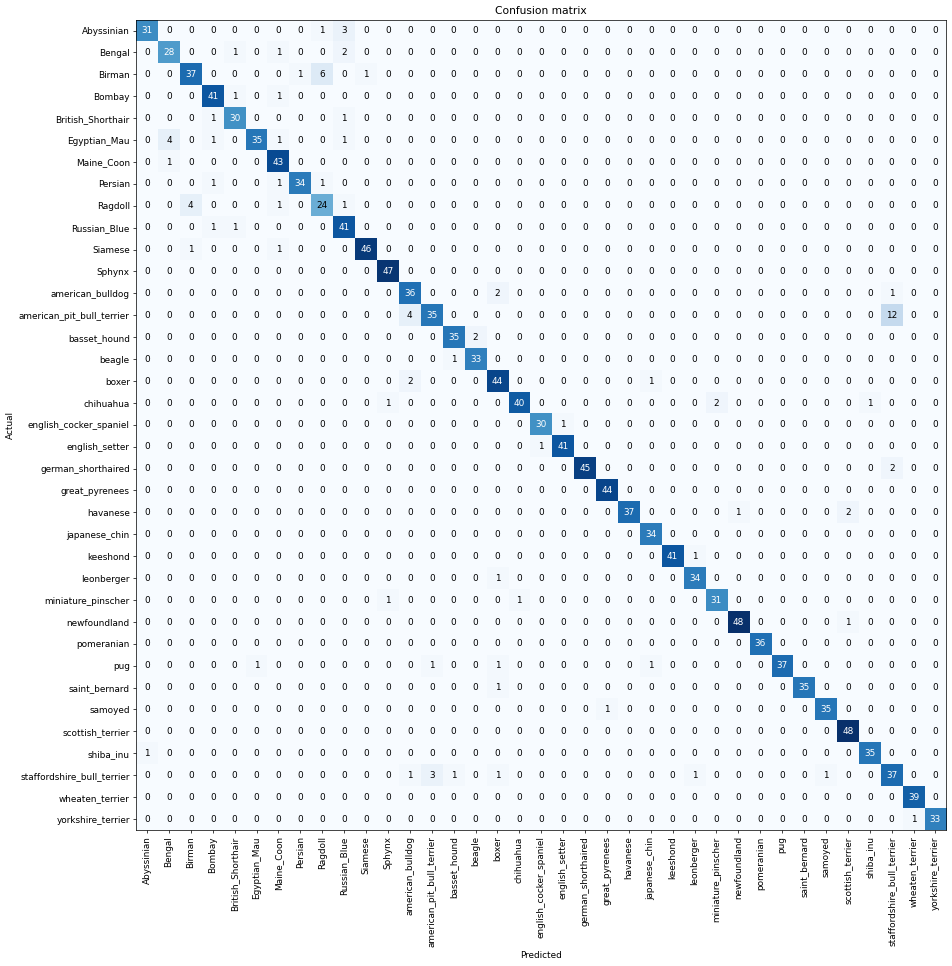

In [23]:
interp.plot_confusion_matrix(figsize=(15, 15), dpi=64)

In [24]:
interp.most_confused(min_val=3)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 12),
 ('Birman', 'Ragdoll', 6),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Ragdoll', 'Birman', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4),
 ('Abyssinian', 'Russian_Blue', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

In [25]:
learn.save("stage2")

Path('models/stage2.pth')